<a href="https://colab.research.google.com/github/chasubeen/ESAA_8th_OB/blob/Week_13/keras_cnn_dog%20or%20cat_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 준비**

## **0-1. 환경설정**
- gpu 장치 확인

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12630050376441260223
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4181262336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1453739404559110380
physical_device_desc: "device: 0, name: GeForce GTX 1660 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5"
]


In [ ]:
import os

# GPU 사용 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## **0-2. Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

import os
print(os.listdir()) # 디렉토리 내 파일 확인

['.ipynb_checkpoints', 'keras-cnn-dog-or-cat-classification.ipynb', 'sampleSubmission.csv', 'test1', 'train']


## **0-3. Define Constants**
- 상수값 설정

In [ ]:
FAST_RUN = False

IMAGE_WIDTH = 128 # 너비
IMAGE_HEIGHT = 128 # 높이
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT) # 사이즈 설정
IMAGE_CHANNELS = 3 # RGB Channel

# **1. 데이터 준비하기기**

## **1-1. 데이터 불러오기**

In [ ]:
# 파일 읽어오기

filenames = os.listdir("./train/train/")
categories = []

for filename in filenames:
    category = filename.split('.')[0]

    if category == 'dog':
        categories.append(1)
    else: # cat
        categories.append(0)

In [ ]:
# 데이터프레임 형태로 가공

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0

In [ ]:
df.tail()

filename  category
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

## **1-2. 데이터 분포 파악하기**

<AxesSubplot:>

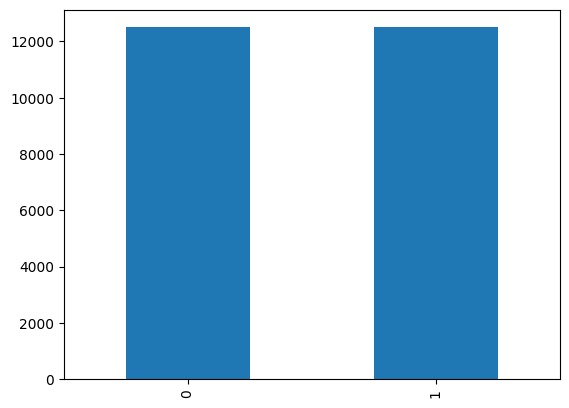

In [ ]:
df['category'].value_counts().plot.bar()

- 고양이(0)와 강아지(1)의 수가 12000으로 동일하다.

## **1-3. 샘플 이미지 출력**

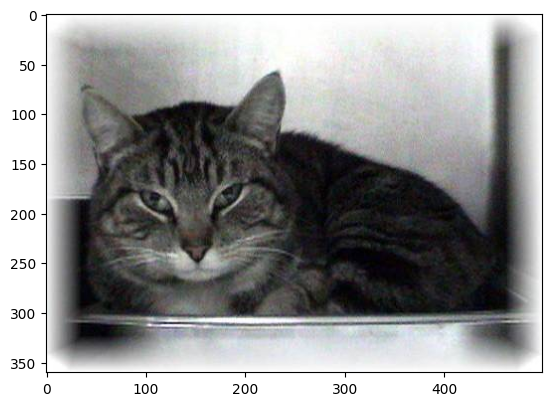

In [ ]:
from PIL import Image

sample = random.choice(filenames)
image = Image.open("./train/train/"+ sample)
plt.imshow(image)

# **2. Modeling**
![img](https://i.imgur.com/ebkMGGu.jpg)

- **입력 레이어(Input Layer)**
    - 입력 이미지 데이터를 나타냄
    - 이미지를 단일 차원 배열로 재구성
        - 예를 들어, 이미지가 64x64 = 4096이면, 이를 (4096, 1) 배열로 변환

- **합성곱 레이어(Conv Layer)**: 이미지에서 특징을 추출하는 레이어

- **풀링 레이어(Pooling Layer)**: 합성곱 이후 입력 이미지의 공간적 볼륨을 줄이는 레이어

- **완전 연결 레이어(Fully Connected Layer)**: 한 레이어에서 다른 레이어로 네트워크를 연결하는 레이어

- **출력 레이어(Output Layer)**: 예측된 값들을 나타내는 레이어

## **2-1. Model Layering**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# 1st Layer
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 2nd Layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 3rd Layer
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# FC Layer
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax')) # 2 because we have cat and dog classes

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

## **2-2. Callback 함수**

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**조기 종료**

- 과적합을 방지하기 위해 학습을 10 epoch 이후에 중단하고 검증 손실 값이 감소하지 않도록 함

In [ ]:
earlystop = EarlyStopping(patience = 10)

**학습률 감소**

- 정확도가 2 step 동안 증가하지 않을 때 학습률을 감소

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)

In [ ]:
# 콜백 함수 정의

callbacks = [earlystop, learning_rate_reduction]

# **3. 데이터 증강(Augmentation)**

## **3-1. 데이터 처리**

### **카테고리화**

- 이미지 생성기(image generator)를 사용할 것이기 때문에 `class_mode="categorical"`로 설정
    - 이를 위해 칼럼을 문자열로 변환해야 함
- 이후 이미지 생성기가 이를 One-hot Encoding으로 변환하여 분류에 적합하게 만들 것임

  > 1을 'dog'(개)로, 0을 'cat'(고양이)로 변환

In [ ]:
# One-hot Encoding

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

### **Train/Valid Set 구축**

In [ ]:
# 데이터 분할

train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42)
train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)

<AxesSubplot:>

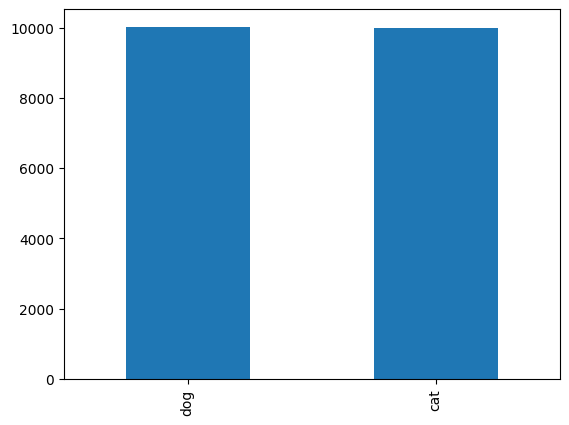

In [ ]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

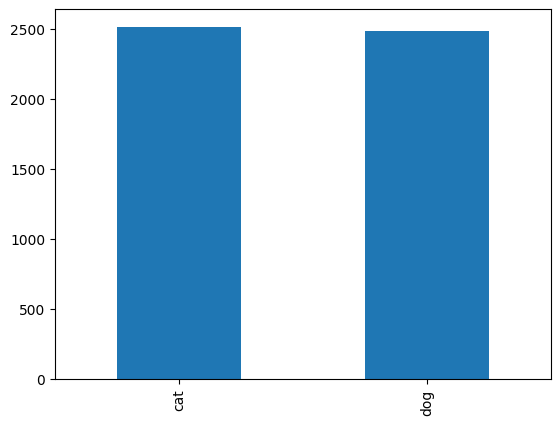

In [ ]:
validate_df['category'].value_counts().plot.bar()

## **3-2. 데이터 증강**

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

### **Train Generator**

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255, # 정규화
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True, # 상하 반전
    width_shift_range = 0.1, # 너비 조정
    height_shift_range=0.1 # 높이 조정
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train/train/",
    x_col='filename',
    y_col='category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### **Validation Generator**

In [ ]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./train/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


### **See how our generator work**
- Image Generator로 생성된 샘플 사진을 확인해보자.

In [ ]:
example_df = train_df.sample(n = 1).reset_index(drop = True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "./train/train/",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical'
)

Found 1 validated image filenames belonging to 1 classes.


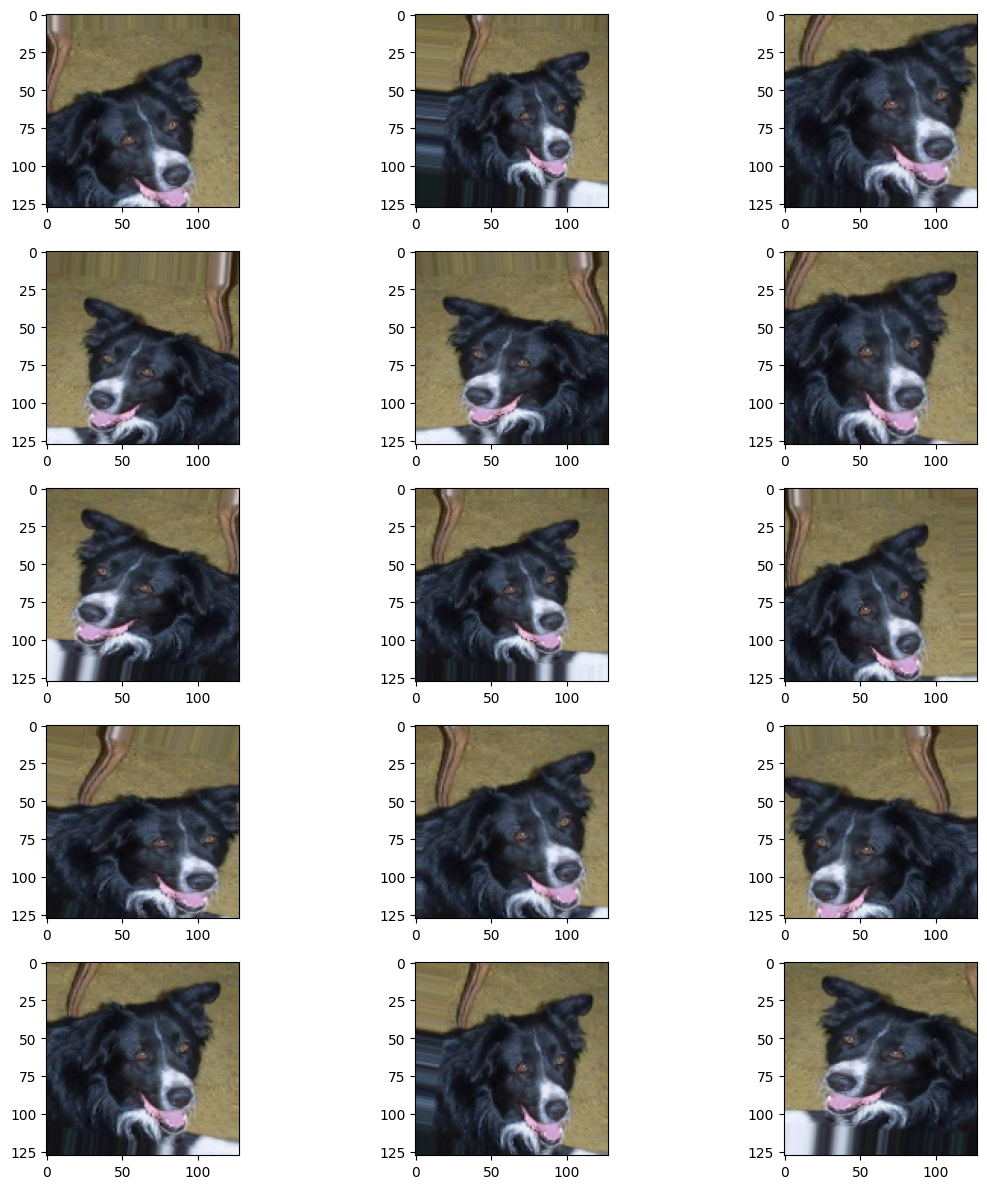

In [ ]:
# 시각화

plt.figure(figsize = (12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

- 꽤나 괜찮은 듯 하다.

# **4. 모델 학습**

## **4-1. Fitting**

In [ ]:
epochs = 3 if FAST_RUN else 50

history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate // batch_size,
    steps_per_epoch = total_train // batch_size,
    callbacks = callbacks
)

C:\Users\BIN\anaconda3\envs\tf25_py37\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
1333/1333 [==============================] - 99s 61ms/step - loss: 0.9856 - accuracy: 0.5995 - val_loss: 0.6109 - val_accuracy: 0.7155
Epoch 2/50
1333/1333 [==============================] - 82s 61ms/step - loss: 0.5689 - accuracy: 0.7141 - val_loss: 0.6330 - val_accuracy: 0.6977
Epoch 3/50
1333/1333 [==============================] - 82s 61ms/step - loss: 0.5203 - accuracy: 0.7495 - val_loss: 0.9616 - val_accuracy: 0.6420

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/50
1333/1333 [==============================] - 82s 61ms/step - loss: 0.4570 - accuracy: 0.7902 - val_loss: 0.4610 - val_accuracy: 0.7946
Epoch 5/50
1333/1333 [==============================] - 82s 61ms/step - loss: 0.4153 - accuracy: 0.8106 - val_loss: 0.4203 - val_accuracy: 0.8038
Epoch 6/50
1333/1333 [==============================] - 82s 61ms/step - loss: 0.3895 - accuracy: 0.8262 - val_loss: 0.4045 - val_accuracy: 0.8356
Epoch 7/50
1333/1333 [=====================

## **4-2. Virtualize Training**
- accuracy, loss 시각화

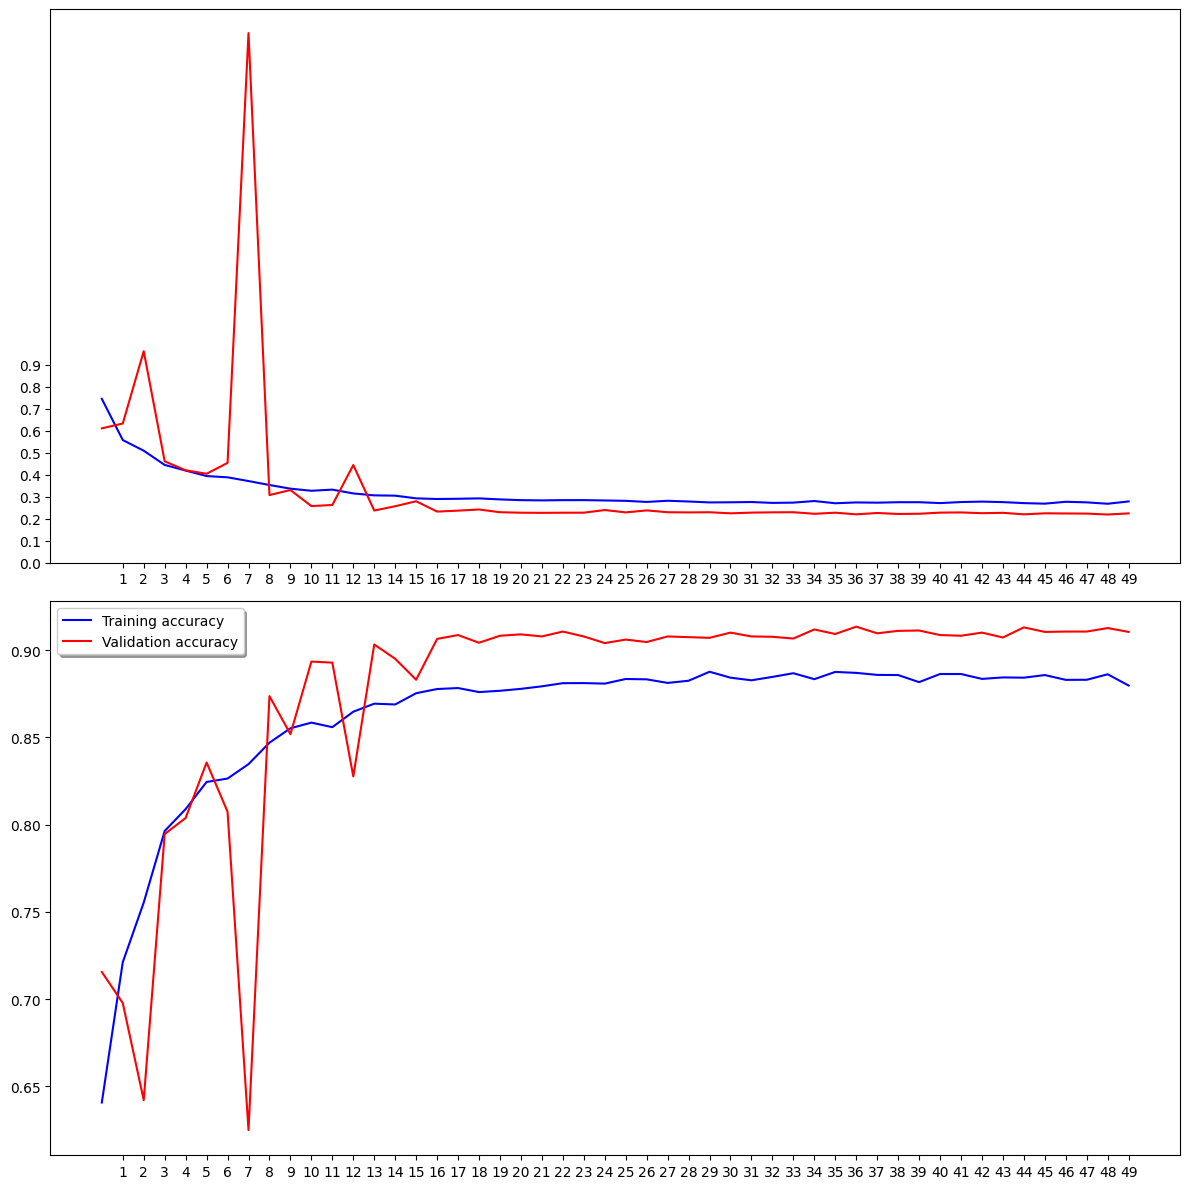

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
ax1.plot(history.history['loss'], color = 'b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

- 꽤나 잘 수렴하고 있는 것으로 판단된다.

### **4-3. Save Model**
- 가중치, bias 등을 저장
  - 이후 재활용(?)할 수 있도록 `.h5` 파일로 저장

In [ ]:
model.save_weights("./model.h5")

# **5. 평가**

## **5-1. Prepare Testing Data**

### **데이터 불러오기**

In [ ]:
test_filenames = os.listdir("./test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

### **Create Testing Generator**

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "./test1/test1/",
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 12500 validated image filenames.


## **5-2. 예측(Predict)**

In [ ]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))

C:\Users\BIN\anaconda3\envs\tf25_py37\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


- 범주형 분류에서 예측은 각 범주에 대한 확률로 도출됨
  - NumPy의 `argmax()`를 사용하여 가장 높은 확률을 갖는 범주를 선택

In [ ]:
test_df['category'] = np.argmax(predict, axis = -1)

- 예측된 범주를 다시 우리의 생성기 클래스로 변환
  - 이를 위해서는 `train_generator.class_indices`를 사용
- 이미지 생성기가 데이터를 컴퓨터 비전으로 변환할 때 매핑하는 클래스

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

- 다시 카테고리화!

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### **Virtaulize Result**

<AxesSubplot:>

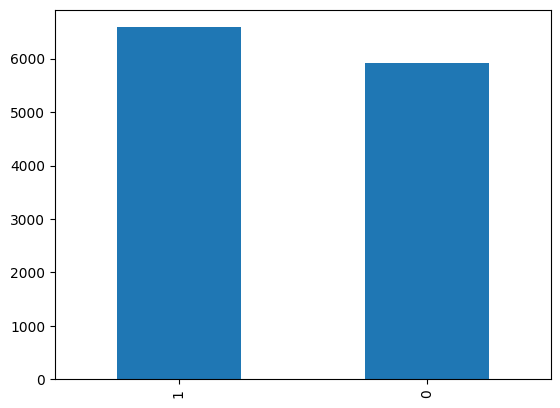

In [ ]:
test_df['category'].value_counts().plot.bar()

### **See predicted result with images**

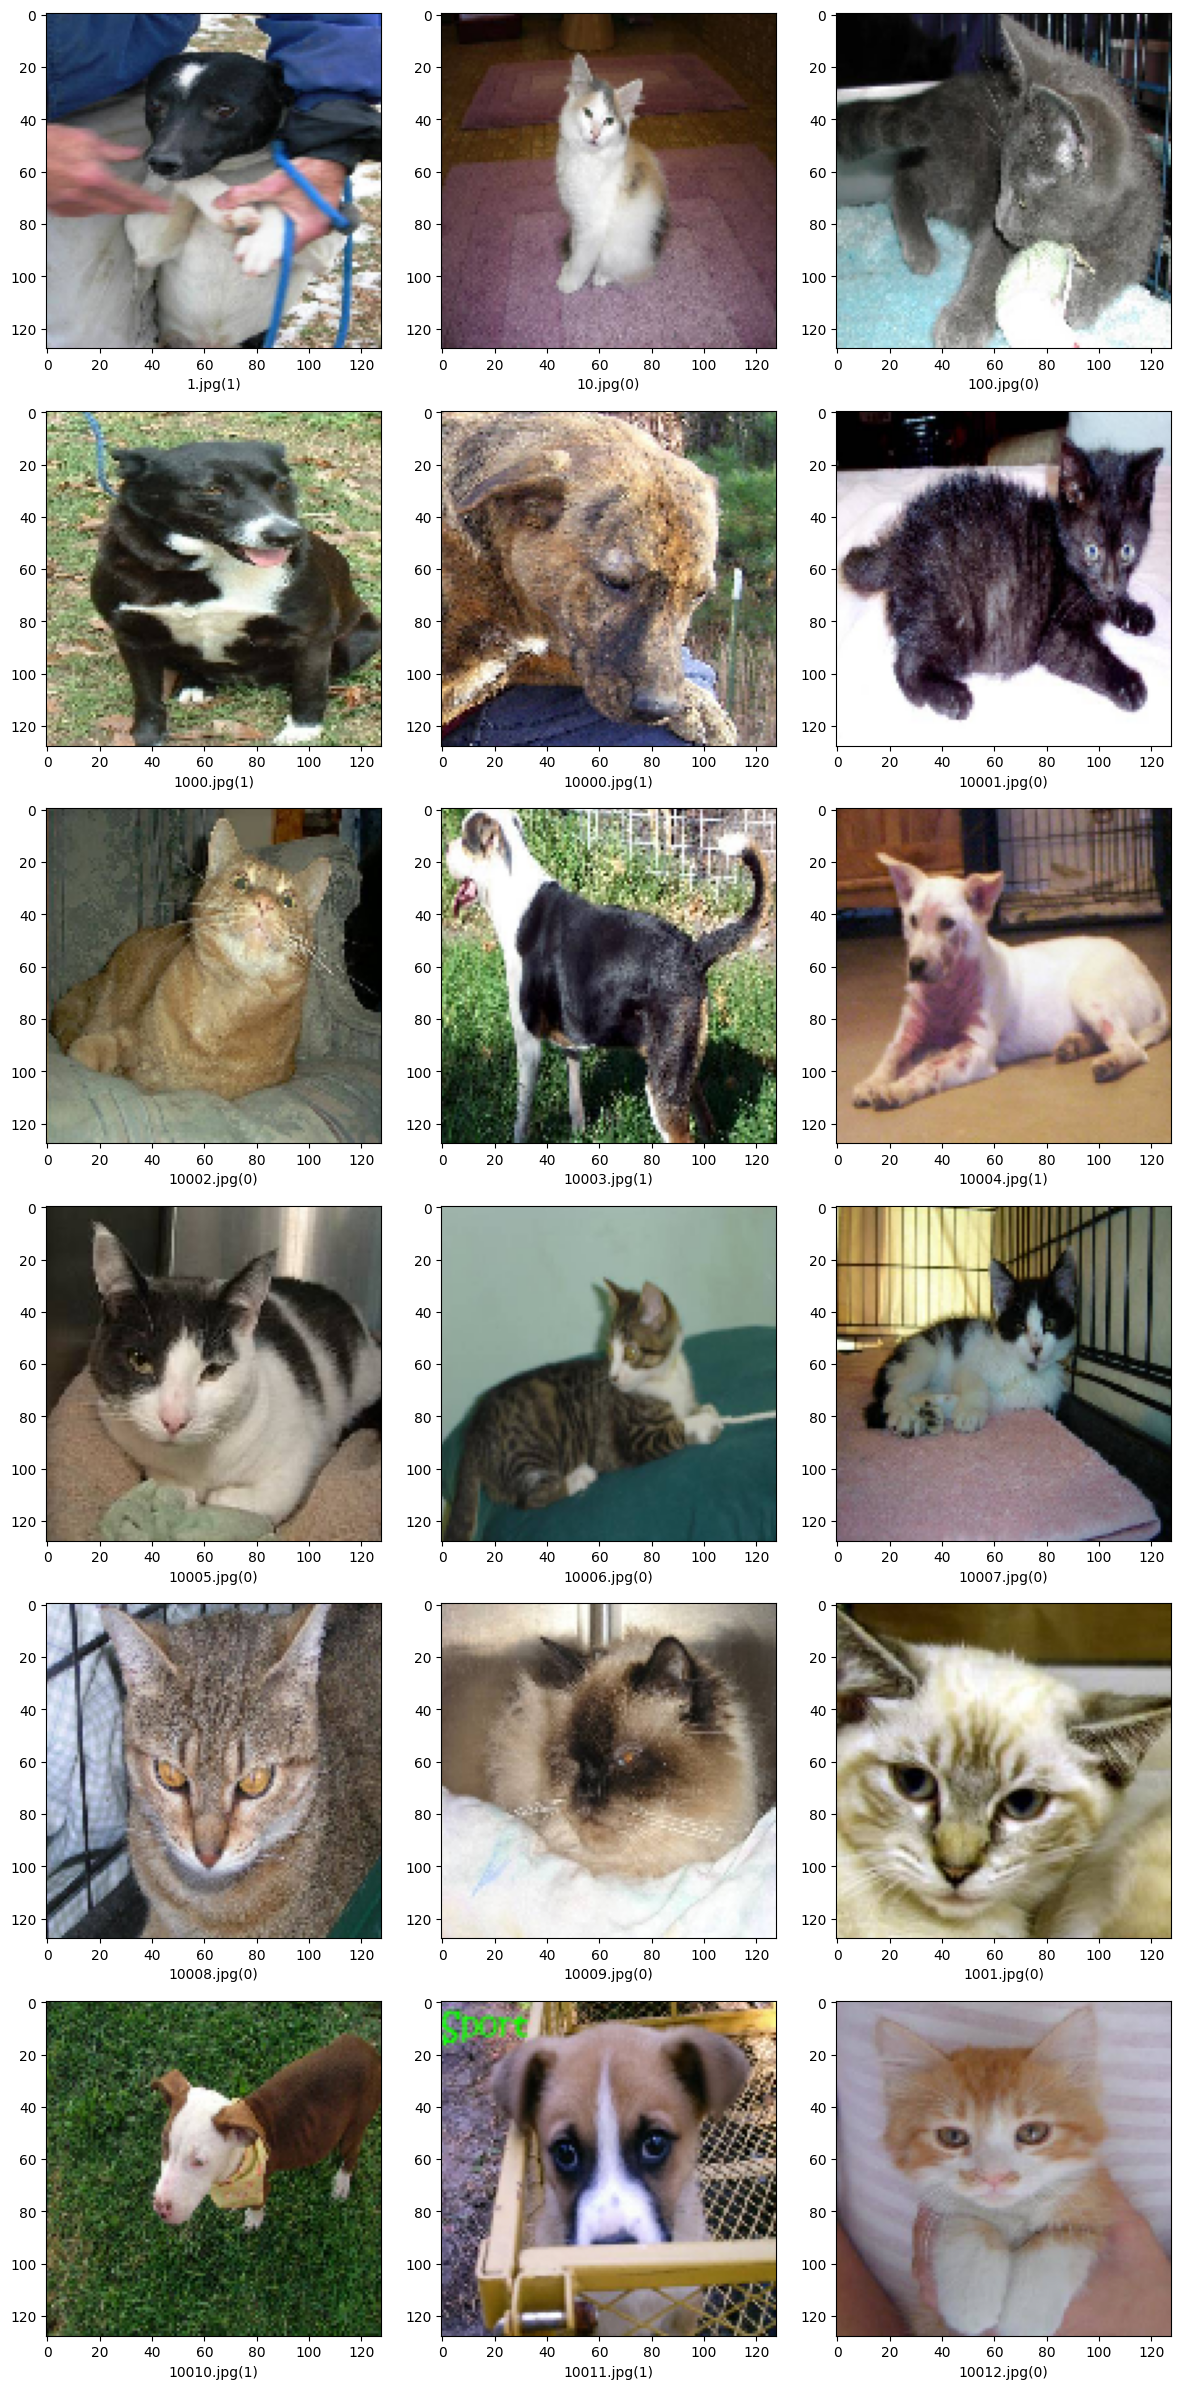

In [ ]:
sample_test = test_df.head(18)
sample_test.head()

plt.figure(figsize = (12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

- 매우 정확하게 고양이와 강아지를 분류해 내고 있다.

# **6. Submission**

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('./submission.csv', index=False)